<a href="https://colab.research.google.com/github/DIFACQUIM/Proyecto_HUAWEI/blob/main/scaffolds_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalaciones...

In [ ]:
!pip install rdkit-pypi mols2grid ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importar bibliotecas necesarias

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
import mols2grid
from tqdm.auto import tqdm
from ipywidgets import widgets
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True 
from google.colab import drive

Enable Pandas **progress_apply**:

In [ ]:
tqdm.pandas()

# Setup

Cargar base de datos con SMILES desde Drive.

In [ ]:
df = pd.read_csv("https://github.com/DIFACQUIM/Proyecto_HUAWEI/raw/main/Datasets/DNMT1_IC50_418_180922_CURADA.csv", usecols=["Smiles", "Molecule ChEMBL ID", "Standard Value", "pChEMBL Value"])
df.head()

,Molecule ChEMBL ID,Smiles,Standard Value,pChEMBL Value
0,CHEMBL2336409,Cc1cc(Nc2ccc(NC(=O)c3ccc(Nc4ccnc5ccccc45)cc3)c...,11220.0,4.95
1,CHEMBL1916683,CN1CC2ON=C(Cc3ccc([N+](=O)[O-])cc3)C2C1,310000.0,NaN
2,CHEMBL3109075,O=C(O)[C@@H]1[C@H](Cc2c[nH]c3ccccc23)CCN1C(=O)...,128000.0,NaN
3,CHEMBL3109080,O=C(O)[C@H](Cc1csc2ccccc12)N1C(=O)c2ccccc2C1=O,230000.0,NaN
4,CHEMBL3126645,Cc1cc(Nc2ccc(NC(=O)c3cccc(Nc4ccnc5ccccc45)c3)c...,265000.0,NaN


Agregar columna de pIC50 al dataframe. Los valores de ChEMBL están reportados en nanomolar, convertir a molar multiplicando por 10^-9.

In [ ]:
df['pIC50'] = -(np.log10(df['Standard Value']*10**-9))
df.tail()

,Molecule ChEMBL ID,Smiles,Standard Value,pChEMBL Value,pIC50
413,CHEMBL4850570,COc1cc2nc(-c3cc(C)oc3C)cc(NCC3CCN(c4ncc(C(=O)N...,10.0,NaN,8.000000
414,CHEMBL4866673,COc1cc2c(NCc3ccc(-c4ccc(C(=O)NO)cc4)cc3)cc(-c3...,2570.0,5.59,5.590067
415,CHEMBL4871621,COc1cc2nc(-c3ccc(C)s3)cc(NCC3CCN(c4ncc(C(=O)NO...,10.0,NaN,8.000000
416,CHEMBL4878570,O=C(NO)C1CCN(CC(O)COC(Cn2c3ccccc3c3ccccc32)Cn2...,2020.0,5.70,5.694649
417,CHEMBL4454542,COc1cc2c(cc1OCCCN1CCCC1)N=C(C1CCCCC1)CN=C2NC1C...,3100.0,5.51,5.508638


Crear una columna con los scaffolds de Bemis/Murcko.

In [ ]:
df['framework'] = df.Smiles.progress_apply(MurckoScaffoldSmilesFromSmiles)

  0%|          | 0/418 [00:00<?, ?it/s]

Crear una columna con objetos moleculares usando RDKit.

In [ ]:
df['mol'] = df.Smiles.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/418 [00:00<?, ?it/s]

# Crear un DataFrame para organizar los scaffolds

Como primer paso, se contaran las frecuencias de cada scaffold. Esto puede hacerse con la función **value_counts** de Pandas. La salida de esta función puede convertirse a un dataframe:

In [ ]:
scaffold_df = df.framework.value_counts().reset_index().copy() # cool trick
scaffold_df.columns = ["scaffold","count"]
# copy the index column for the dataframe to scaffold_idx
scaffold_df['scaffold_idx'] = scaffold_df.index
scaffold_df

,scaffold,count,scaffold_idx
0,c1coc(-c2cc(NC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,16,0
1,c1ncc2ncn(C3CCCO3)c2n1,11,1
2,c1ncc2ncn(C3CCC(CSC4CCNC4)O3)c2n1,8,2
3,c1ccc(C2=NOC3(CCNC3)C2)cc1,5,3
4,c1ccc(-c2ccc(CCNc3ncnc4c3ncn4C3CCC(CSC4CCNC4)O...,4,4
...,...,...,...
322,c1ccc(SN2CCC(Cc3c[nH]c4ccccc34)C2)cc1,1,322
323,c1ccc(CC2=NOCC2)cc1,1,323
324,c1csc(-c2cc(NC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,1,324
325,c1coc(-c2nc(NC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,1,325


Ahora creamos un enlace entre los datos del dataframe inicial (df) y el dataframe que contiene a los scaffolds (scaffold_df). Para esto, se crea un diccionario que mapea el scaffold de df a un número entero correspondiente al índice en scaffold_df.


In [ ]:
scaffold_dict = dict(zip(scaffold_df.scaffold,scaffold_df.index))
df['scaffold_idx'] = [scaffold_dict[x] for x in df.framework]

# Examinar las estructuras

Generar coordenadas 2D para los scaffolds:

In [ ]:
scaffold_df['mol'] = scaffold_df['scaffold'].apply(Chem.MolFromSmiles)
crds_ok = scaffold_df.mol.progress_apply(AllChem.Compute2DCoords)

  0%|          | 0/327 [00:00<?, ?it/s]

Verificar presencia de ChEMBL ID de interés en el dataframe:

In [ ]:
(df['Molecule ChEMBL ID'] == "CHEMBL418052").value_counts()

False    417
True       1
Name: Molecule ChEMBL ID, dtype: int64

Búsqueda de los ID's de SAH, azacitidina y decitabina (análogos de nucleósidos):

In [ ]:
nucleosidos = df[(df['Molecule ChEMBL ID'] == "CHEMBL418052") | (df['Molecule ChEMBL ID'] == "CHEMBL1489") | (df['Molecule ChEMBL ID'] == "CHEMBL1201129")]
nucleosidos

,Molecule ChEMBL ID,Smiles,Standard Value,pChEMBL Value,pIC50,framework,mol,scaffold_idx
54,CHEMBL418052,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O...,900.0,6.05,6.045757,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb03568b890>,1
293,CHEMBL1489,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,300.0,6.52,6.522879,O=c1ncncn1C1CCCO1,<rdkit.Chem.rdchem.Mol object at 0x7fb0356912e0>,29
410,CHEMBL1201129,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1,30.0,7.52,7.522879,O=c1ncncn1C1CCCO1,<rdkit.Chem.rdchem.Mol object at 0x7fb0356946d0>,29


Definir nueva variable con el SMILES del scaffold encontrado para los compuestos:

In [ ]:
 scaffold_nucleosidos = list((nucleosidos['framework']).unique())
 scaffold_nucleosidos

['c1ncc2ncn(C3CCCO3)c2n1', 'O=c1ncncn1C1CCCO1']

Visualización de scaffolds encontrados:

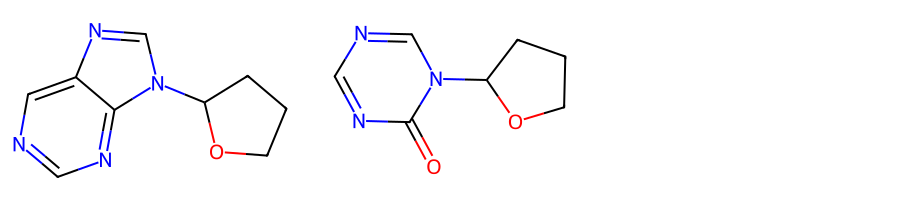

In [ ]:
Scaffolds = [Chem.MolFromSmiles(x) for x in scaffold_nucleosidos]
MOL =Chem.Draw.MolsToGridImage(Scaffolds, molsPerRow=3, subImgSize=(300, 200))
MOL

Búsqueda de compuestos con el mismo scaffold:

In [ ]:
df[df['scaffold_idx'] == 1]

,Molecule ChEMBL ID,Smiles,Standard Value,pChEMBL Value,pIC50,framework,mol,scaffold_idx
49,CHEMBL558406,CSc1nc(N)c2ncn([C@@H]3O[C@H](CSCCC(N)C(=O)O)[C...,216000.0,NaN,3.665546,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb03568b660>,1
54,CHEMBL418052,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O...,900.0,6.05,6.045757,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb03568b890>,1
57,CHEMBL558882,Nc1nc(I)nc2c1ncn2[C@@H]1O[C@H](CSCCC(N)C(=O)O)...,21000.0,4.68,4.677781,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb03568b9e0>,1
95,CHEMBL564768,Nc1nc(Cl)nc2c1ncn2[C@@H]1O[C@H](CSCCC(N)C(=O)O...,2900.0,5.54,5.537602,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb035684ac0>,1
97,CHEMBL563570,N[C@@H](CCSC[C@H]1O[C@@H](n2cnc3cncnc32)[C@H](...,300000.0,NaN,3.522879,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb035684ba0>,1
98,CHEMBL538692,Nc1nc(F)nc2c1ncn2[C@@H]1O[C@H](CSCCC(N)C(=O)O)...,2500.0,5.60,5.602060,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb035684c10>,1
99,CHEMBL560165,COc1nc(N)c2ncn([C@@H]3O[C@H](CSCCC(N)C(=O)O)[C...,75000.0,4.12,4.124939,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb035684c80>,1
116,CHEMBL538693,NCCCSC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[...,45000.0,NaN,4.346787,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb03568c430>,1
155,CHEMBL563938,NCCSC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C...,18000.0,4.75,4.744727,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb03568d580>,1
204,CHEMBL560045,Cc1nc(N)c2ncn([C@@H]3O[C@H](CSCCC(N)C(=O)O)[C@...,6000.0,5.22,5.221849,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x7fb03568eb30>,1


# Usar mols2grid para visualizar scaffolds y las moléculas asociadas

En la cuadrícula superior se muestran los scaffolds de Bemis-Murcko, el número de moléculas con ese scaffold y su índice. Al hacer click en la estructura de un scaffold se despliega una segunda cuadrícula con las moléculas que tienen presente dicho scaffold junto con sus valores de pIC50.


In [ ]:
# set the size of the structures in both grids
structure_size=(195,195)
# in order to do display an output from the callback, we need to instantiate an
# instance of widgets.Ouput().  Note that the final call in this cell displays
# "output"
output = widgets.Output()
@output.capture(clear_output=True, wait=True)
def show_details(data):
    idx = int(data["scaffold_idx"])
    detail_df = df.query("scaffold_idx == @idx")
    cols_to_display = ["SMILES","pIC50","mol"]
    detail_grid = mols2grid.MolGrid(detail_df, mol_col="mol",name=f"details_{idx}",size=structure_size)
    detail_view = detail_grid.display(n_rows=2,n_cols=4,subset=["img","pIC50"],selection=False)
    display(detail_view)

# This code block is necessary to make the callback work on colab
try:
    from google import colab
except:
    pass
else:
    colab.output.register_callback("show_details", show_details)

# define the grid to show the scafffolds
scaffold_grid = mols2grid.MolGrid(scaffold_df, name="centers",mol_col="mol",size=structure_size)
scaffold_view = scaffold_grid.display(n_rows=2,
                                    n_cols=4,
                                    subset=["img","count","scaffold_idx"],
                                    selection=True,
                                    callback=show_details)
display(scaffold_view)
# show the detail grid
output

MolGridWidget(grid_id='centers')

Output()

# Búsqueda de subestructuras

Definir búsqueda con el SMARTS del scaffold de elección y buscar en el dataframe:

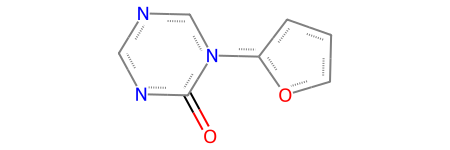

In [ ]:
Aza_scaffold = "O=c1ncncn1C1CCCO1"
query = Chem.MolFromSmarts(Aza_scaffold)
query

Crear una nueva columna para indicar si la molécula contiene o no a la subestructura:

In [ ]:
df['match'] = [x.HasSubstructMatch(query) for x in df.mol]

Conteo de moléculas con la subestructura presente:

In [ ]:
df.match.value_counts()

False    416
True       2
Name: match, dtype: int64

Eliminar las moléculas que contengan el scaffold y examinar las restantes:

In [ ]:
scaf_df_v2 = df.query('match==False').framework.value_counts().reset_index()
scaf_df_v2.columns = ["Scaffold","Count"]
mols2grid.display(scaf_df_v2,smiles_col="Scaffold")

MolGridWidget()

Crear un nuevo dataframe con las moléculas que no contienen a la subestructura de búsqueda:

In [ ]:
df['match'] = [x.HasSubstructMatch(query) for x in df.mol]
df_v2 = df[df['match'] == False]
df_v2

,Molecule ChEMBL ID,Smiles,Standard Value,pChEMBL Value,pIC50,framework,mol,scaffold_idx,match
0,CHEMBL2336409,Cc1cc(Nc2ccc(NC(=O)c3ccc(Nc4ccnc5ccccc45)cc3)c...,11220.0,4.95,4.950007,O=C(Nc1ccc(Nc2ccncn2)cc1)c1ccc(Nc2ccnc3ccccc23...,<rdkit.Chem.rdchem.Mol object at 0x7fb036fc6f20>,105,False
1,CHEMBL1916683,CN1CC2ON=C(Cc3ccc([N+](=O)[O-])cc3)C2C1,310000.0,NaN,3.508638,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee60b0>,38,False
2,CHEMBL3109075,O=C(O)[C@@H]1[C@H](Cc2c[nH]c3ccccc23)CCN1C(=O)...,128000.0,NaN,3.892790,O=C(c1ccc2ccccc2c1)N1CCC(Cc2c[nH]c3ccccc23)C1,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee6190>,235,False
3,CHEMBL3109080,O=C(O)[C@H](Cc1csc2ccccc12)N1C(=O)c2ccccc2C1=O,230000.0,NaN,3.638272,O=C1c2ccccc2C(=O)N1CCc1csc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee6200>,234,False
4,CHEMBL3126645,Cc1cc(Nc2ccc(NC(=O)c3cccc(Nc4ccnc5ccccc45)c3)c...,265000.0,NaN,3.576754,O=C(Nc1ccc(Nc2ccncn2)cc1)c1cccc(Nc2ccnc3ccccc2...,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee6270>,233,False
...,...,...,...,...,...,...,...,...,...
413,CHEMBL4850570,COc1cc2nc(-c3cc(C)oc3C)cc(NCC3CCN(c4ncc(C(=O)N...,10.0,NaN,8.000000,c1cnc(N2CCC(CNc3cc(-c4ccoc4)nc4ccccc34)CC2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7fb035694820>,131,False
414,CHEMBL4866673,COc1cc2c(NCc3ccc(-c4ccc(C(=O)NO)cc4)cc3)cc(-c3...,2570.0,5.59,5.590067,c1ccc(-c2ccc(CNc3cc(-c4ccco4)nc4cc(OCCCN5CCCC5...,<rdkit.Chem.rdchem.Mol object at 0x7fb035694890>,130,False
415,CHEMBL4871621,COc1cc2nc(-c3ccc(C)s3)cc(NCC3CCN(c4ncc(C(=O)NO...,10.0,NaN,8.000000,c1cnc(N2CCC(CNc3cc(-c4cccs4)nc4ccccc34)CC2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7fb035694900>,129,False
416,CHEMBL4878570,O=C(NO)C1CCN(CC(O)COC(Cn2c3ccccc3c3ccccc32)Cn2...,2020.0,5.70,5.694649,c1ccc2c(c1)c1ccccc1n2CC(Cn1c2ccccc2c2ccccc21)O...,<rdkit.Chem.rdchem.Mol object at 0x7fb035694970>,128,False


Repetir el ciclo con scaffolds elegidos...

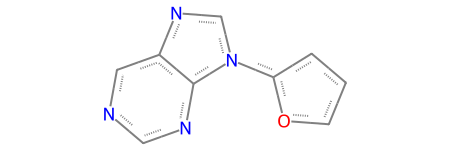

In [ ]:
SAH_scaffold = "c1ncc2ncn(C3CCCO3)c2n1" 
query = Chem.MolFromSmarts(SAH_scaffold)
query

In [ ]:
df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]

<ipython-input-62-9dce8d294057>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]


In [ ]:
df_v2.match.value_counts()

False    377
True      39
Name: match, dtype: int64

In [ ]:
scaf_df_v3 = df_v2.query('match==False').framework.value_counts().reset_index()
scaf_df_v3.columns = ["Scaffold","Count"]
mols2grid.display(scaf_df_v3,smiles_col="Scaffold")

MolGridWidget()

In [ ]:
df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]
df_v3 = df_v2[df_v2['match'] == False]
df_v3

<ipython-input-65-3438a80dcb94>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]


,Molecule ChEMBL ID,Smiles,Standard Value,pChEMBL Value,pIC50,framework,mol,scaffold_idx,match
0,CHEMBL2336409,Cc1cc(Nc2ccc(NC(=O)c3ccc(Nc4ccnc5ccccc45)cc3)c...,11220.0,4.95,4.950007,O=C(Nc1ccc(Nc2ccncn2)cc1)c1ccc(Nc2ccnc3ccccc23...,<rdkit.Chem.rdchem.Mol object at 0x7fb036fc6f20>,105,False
1,CHEMBL1916683,CN1CC2ON=C(Cc3ccc([N+](=O)[O-])cc3)C2C1,310000.0,NaN,3.508638,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee60b0>,38,False
2,CHEMBL3109075,O=C(O)[C@@H]1[C@H](Cc2c[nH]c3ccccc23)CCN1C(=O)...,128000.0,NaN,3.892790,O=C(c1ccc2ccccc2c1)N1CCC(Cc2c[nH]c3ccccc23)C1,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee6190>,235,False
3,CHEMBL3109080,O=C(O)[C@H](Cc1csc2ccccc12)N1C(=O)c2ccccc2C1=O,230000.0,NaN,3.638272,O=C1c2ccccc2C(=O)N1CCc1csc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee6200>,234,False
4,CHEMBL3126645,Cc1cc(Nc2ccc(NC(=O)c3cccc(Nc4ccnc5ccccc45)c3)c...,265000.0,NaN,3.576754,O=C(Nc1ccc(Nc2ccncn2)cc1)c1cccc(Nc2ccnc3ccccc2...,<rdkit.Chem.rdchem.Mol object at 0x7fb036ee6270>,233,False
...,...,...,...,...,...,...,...,...,...
413,CHEMBL4850570,COc1cc2nc(-c3cc(C)oc3C)cc(NCC3CCN(c4ncc(C(=O)N...,10.0,NaN,8.000000,c1cnc(N2CCC(CNc3cc(-c4ccoc4)nc4ccccc34)CC2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7fb035694820>,131,False
414,CHEMBL4866673,COc1cc2c(NCc3ccc(-c4ccc(C(=O)NO)cc4)cc3)cc(-c3...,2570.0,5.59,5.590067,c1ccc(-c2ccc(CNc3cc(-c4ccco4)nc4cc(OCCCN5CCCC5...,<rdkit.Chem.rdchem.Mol object at 0x7fb035694890>,130,False
415,CHEMBL4871621,COc1cc2nc(-c3ccc(C)s3)cc(NCC3CCN(c4ncc(C(=O)NO...,10.0,NaN,8.000000,c1cnc(N2CCC(CNc3cc(-c4cccs4)nc4ccccc34)CC2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7fb035694900>,129,False
416,CHEMBL4878570,O=C(NO)C1CCN(CC(O)COC(Cn2c3ccccc3c3ccccc32)Cn2...,2020.0,5.70,5.694649,c1ccc2c(c1)c1ccccc1n2CC(Cn1c2ccccc2c2ccccc21)O...,<rdkit.Chem.rdchem.Mol object at 0x7fb035694970>,128,False


**Fuente:**
http://practicalcheminformatics.blogspot.com/2021/10/exploratory-data-analysis-with.html